# Object detection with DETR

There are few key differences between a normal transformer network and DETR.
Primarily, our input is an image, not a sequence. So, DETR passes the image through
a ResNet backbone to get a vector of size 256 that can be then treated as a sequence. In
our case, the inputs to the decoder are object-query embeddings, which are
automatically learned during training. These act as the query matrices for all the
decoder layers. Similarly, for every layer, the key and query matrices are going to be
the final output matrix from the encoder block, replicated twice. The final output of
the transformer is going to be a Batch_Size x 100 x Embedding_Size tensor, where
the model has been trained with 100 as the sequence length; that is, it learned 100
object-query embeddings and returns 100 vectors per image, indicating whether there
is an object or not. These 100 x Embedding_Size matrices are individually fed to an
object classification module and object regression module, which independently
predict whether there's an object (and what it is) and what the bounding box
coordinates are, respectively. Both of these modules are simple nn.Linear layers.

![trans](../imgs/trans6.png)

In [1]:
import os
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets torchsummary
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/detr/
%cd detr

Cloning into 'detr'...
remote: Enumerating objects: 283, done.
remote: Total 283 (delta 0), reused 0 (delta 0), pack-reused 283
Receiving objects: 100% (283/283), 12.88 MiB | 1.96 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/home/lacie/Github/Jellyfish-with-ComputerVision/Theory/Modern-ComputerVision-with-Pytorch/09-Combining-Computer-Vision-with-Other-Techniques/NLP/detr


In [2]:
%cd ../open-images-bus-trucks/annotations
!cp mini_open_images_train_coco_format.json instances_train2017.json
!cp mini_open_images_val_coco_format.json instances_val2017.json
%cd ..
!ln -s images/ train2017
!ln -s images/ val2017
%cd ../detr

/home/lacie/Github/Jellyfish-with-ComputerVision/Theory/Modern-ComputerVision-with-Pytorch/09-Combining-Computer-Vision-with-Other-Techniques/NLP/open-images-bus-trucks/annotations
/home/lacie/Github/Jellyfish-with-ComputerVision/Theory/Modern-ComputerVision-with-Pytorch/09-Combining-Computer-Vision-with-Other-Techniques/NLP/open-images-bus-trucks
/home/lacie/Github/Jellyfish-with-ComputerVision/Theory/Modern-ComputerVision-with-Pytorch/09-Combining-Computer-Vision-with-Other-Techniques/NLP/detr


In [3]:
CLASSES = ['', 'BUS','TRUCK']

In [4]:
from torch_snippets import *
if not os.path.exists('detr-r50-e632da11.pth'):
    !wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
    checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu')
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]
    torch.save(checkpoint,"detr-r50_no-class-head.pth")

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--2023-08-16 16:23:31--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.14.92, 108.157.14.94, 108.157.14.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.14.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth’

detr-r50-e632da11.p 100%[===================>] 158,90M  11,1MB/s    in 14s     

2023-08-16 16:23:46 (11,0 MB/s) - ‘detr-r50-e632da11.pth’ saved [166618694/166618694]



In [8]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:~/miniconda3/lib
!python main.py --coco_path ../open-images-bus-trucks/\
  --epochs 10 --lr=1e-4 --batch_size=2 --num_workers=4\
  --output_dir="outputs" --resume="detr-r50_no-class-head.pth"

Traceback (most recent call last):
  File "main.py", line 16, in <module>
    from engine import evaluate, train_one_epoch
  File "/home/lacie/Github/Jellyfish-with-ComputerVision/Theory/Modern-ComputerVision-with-Pytorch/09-Combining-Computer-Vision-with-Other-Techniques/NLP/detr/engine.py", line 13, in <module>
    from datasets.coco_eval import CocoEvaluator
  File "/home/lacie/Github/Jellyfish-with-ComputerVision/Theory/Modern-ComputerVision-with-Pytorch/09-Combining-Computer-Vision-with-Other-Techniques/NLP/detr/datasets/coco_eval.py", line 16, in <module>
    from pycocotools.coco import COCO
  File "/home/lacie/miniconda3/envs/conda-pytorch/lib/python3.8/site-packages/pycocotools/coco.py", line 49, in <module>
    import matplotlib.pyplot as plt
  File "/home/lacie/.local/lib/python3.8/site-packages/matplotlib/__init__.py", line 227, in <module>
    _check_versions()
  File "/home/lacie/.local/lib/python3.8/site-packages/matplotlib/__init__.py", line 221, in _check_versions
    

In [ ]:
from main import get_args_parser, argparse, build_model
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args, _ = parser.parse_known_args()

model, _, _ = build_model(args)
model.load_state_dict(torch.load("outputs/checkpoint.pth")['model']);

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# standard PyTorch mean-std input image normalization
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
          
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
    
def detect(im, model, transform):
    img = transform(im).unsqueeze(0)
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'
    outputs = model(img)
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

2020-10-03 05:38:23.562 | INFO     | torch_snippets.loader:Glob:160 - 15225 files found at ../open-images-bus-trucks/images/*


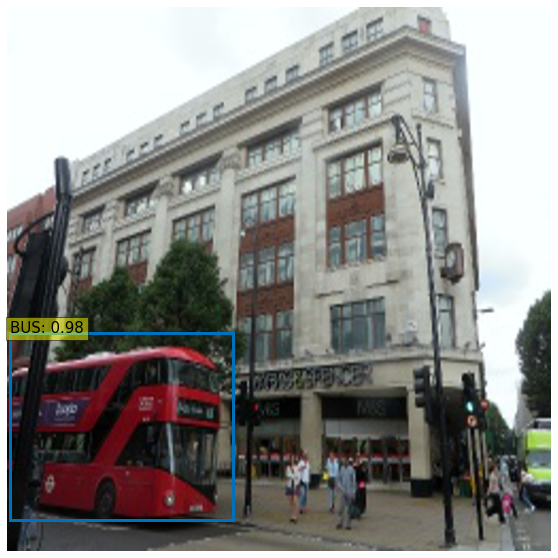

2020-10-03 05:38:26.715 | INFO     | torch_snippets.loader:Glob:160 - 15225 files found at ../open-images-bus-trucks/images/*


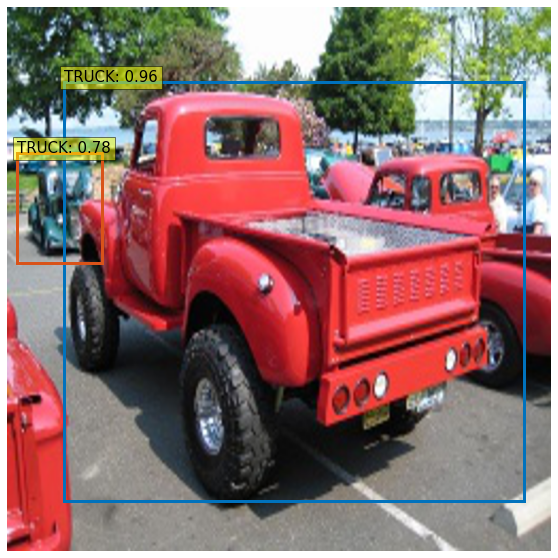

In [ ]:
for _ in range(2):
    image = Image.open(choose(Glob('../open-images-bus-trucks/images/*'))).resize((800,800)).convert('RGB')
    scores, boxes = detect(image, model, transform)
    plot_results(image, scores, boxes)